In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ast

# Kaggle directory
dir = '/kaggle/input/the-movies-dataset/'

# Load datasets
ratings = pd.read_csv(dir + 'ratings_small.csv')
metadata = pd.read_csv(dir + 'movies_metadata.csv', low_memory=False)
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Setup option
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}') 

In [4]:
# Create DateFrames
keywords_df = pd.read_csv("/kaggle/input/the-movies-dataset/keywords.csv")
credits_df = pd.read_csv("/kaggle/input/the-movies-dataset/credits.csv")
movies_df = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv", low_memory=False)

In [5]:
keywords_df.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [6]:
movies_df.describe()

,revenue,runtime,vote_average,vote_count
count,"45,460.000","45,203.000","45,460.000","45,460.000"
mean,"11,209,348.539",94.128,5.618,109.897
std,"64,332,246.741",38.408,1.924,491.310
min,0.000,0.000,0.000,0.000
25%,0.000,85.000,5.000,3.000
50%,0.000,95.000,6.000,10.000
75%,0.000,107.000,6.800,34.000
max,"2,787,965,087.000","1,256.000",10.000,"14,075.000"


In [7]:
metadata = metadata.rename(columns={'id': 'movieId'})
metadata['movieId'] = pd.to_numeric(metadata['movieId'], errors='coerce')

# Merge the two DataFrames on the 'movieId' column
combined_data = pd.merge(ratings, metadata, on='movieId')

# Filter users who have rated 20 or more movies
user_rating_counts = combined_data.groupby('userId')['rating'].count()
active_users = user_rating_counts[user_rating_counts >= 20].index

df = combined_data[combined_data['userId'].isin(active_users)]
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'adult',
       'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count'],
      dtype='object')

In [8]:
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
movies_df['id'] = movies_df['id'].fillna(0).astype('int64')

# Check for duplicates in movies_df['id']
print(f"There are {movies_df.duplicated('id').sum()} duplicates in the 'id'.")

# Set index to 'id' and remove 'imdb_id'
movies_df.set_index('id', inplace=True)
movies_df.drop('imdb_id', axis=1, inplace=True)

There are 32 duplicates in the 'id'.


In [9]:
credits_df[credits_df.duplicated('id', keep=False)]
print(f"There were {credits_df.duplicated('id').sum()} duplicates in the variable credits['id'].")
credits_df.drop_duplicates('id', inplace=True)
print(f"Now, there is {credits_df.duplicated('id').sum()} duplicates in the variable credits['id'].")

keywords_df[keywords_df.duplicated('id', keep=False)]
print(f"There were {keywords_df.duplicated('id').sum()} duplicates in the variable keywords['id'].")
keywords_df.drop_duplicates('id', inplace=True)
print(f"Now, there is {keywords_df.duplicated('id').sum()} duplicates in the variable keywords['id'].")

There were 44 duplicates in the variable credits['id'].
Now, there is 0 duplicates in the variable credits['id'].
There were 987 duplicates in the variable keywords['id'].
Now, there is 0 duplicates in the variable keywords['id'].


In [10]:
def get_name(x):
    return [i['name'] for i in x]

def select_first_5_values(x):
    return x[:5]

credits_df['main_actors'] = credits_df['cast'].apply(ast.literal_eval).apply(get_name).apply(select_first_5_values)

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

credits_df['director'] = credits_df['crew'].apply(ast.literal_eval).apply(get_director)

In [11]:
collection_df = movies_df.copy()
collection_df.reset_index(inplace=True)
collection_df = collection_df[['id', 'belongs_to_collection']].set_index('id')
collection_df['belongs_to_collection'] = collection_df['belongs_to_collection'].fillna("[]") \
    .apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
collection_df = collection_df.dropna()

print(collection_df)

                 belongs_to_collection
id                                    
862               Toy Story Collection
15602        Grumpy Old Men Collection
11862   Father of the Bride Collection
710              James Bond Collection
21032                 Balto Collection
...                                ...
24568          The Carry On Collection
19307          The Carry On Collection
21251          The Carry On Collection
460135  DC Super Hero Girls Collection
182030            Red Lotus Collection

[4491 rows x 1 columns]


In [12]:
movies_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

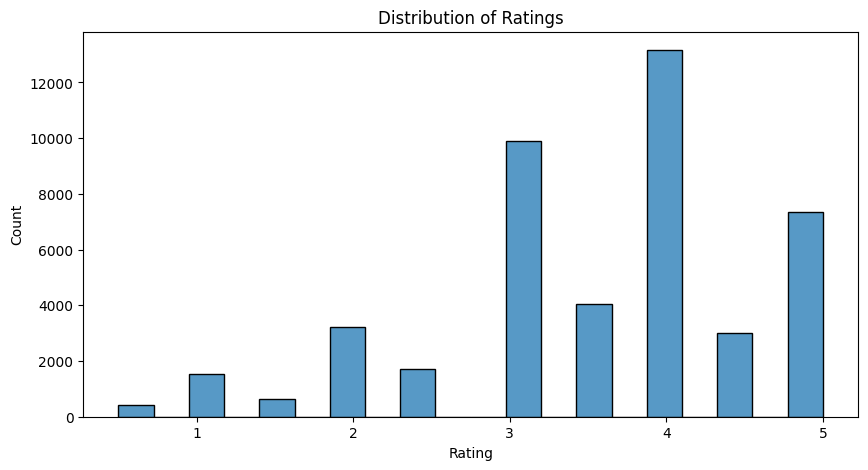

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Convert 'release_date' to datetime format
combined_data['release_date'] = pd.to_datetime(combined_data['release_date'], errors='coerce')

# Convert 'genres' from JSON format to a list of genres
def parse_genres(genres_str):
    genres = json.loads(genres_str.replace("'", "\""))
    genres_list = [g['name'] for g in genres]
    return genres_list

combined_data['genres'] = combined_data['genres'].apply(parse_genres)

# Extract year from 'release_date' and create 'release_year' column
combined_data['release_year'] = combined_data['release_date'].dt.year

# Plot distribution of ratings
plt.figure(figsize=(10, 5))
sns.histplot(combined_data['rating'], bins=20, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

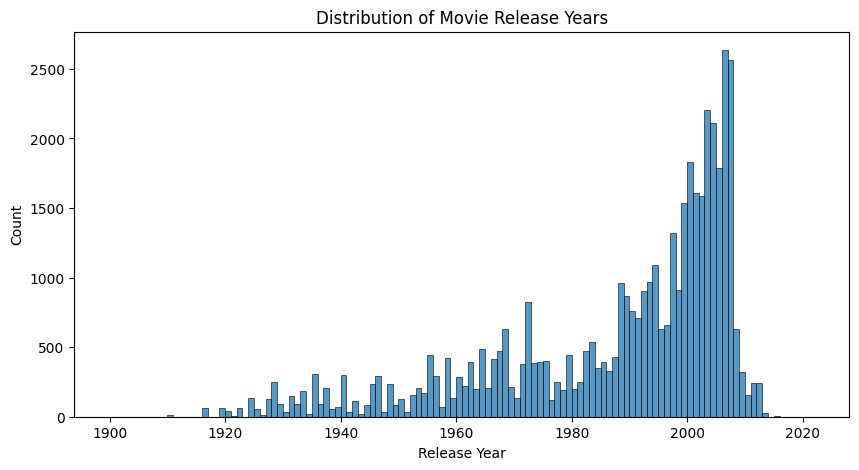

In [14]:
#distribution of movie release years
plt.figure(figsize=(10, 5))
sns.histplot(combined_data['release_year'], bins=np.arange(1900, 2023, 1))
plt.title('Distribution of Movie Release Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

In [15]:
#number of movies for each genre
all_genres = np.concatenate(combined_data['genres'].values)
unique_genres, counts = np.unique(all_genres, return_counts=True)
genre_counts = pd.DataFrame({'genre': unique_genres, 'count': counts}).sort_values(by='count', ascending=False)

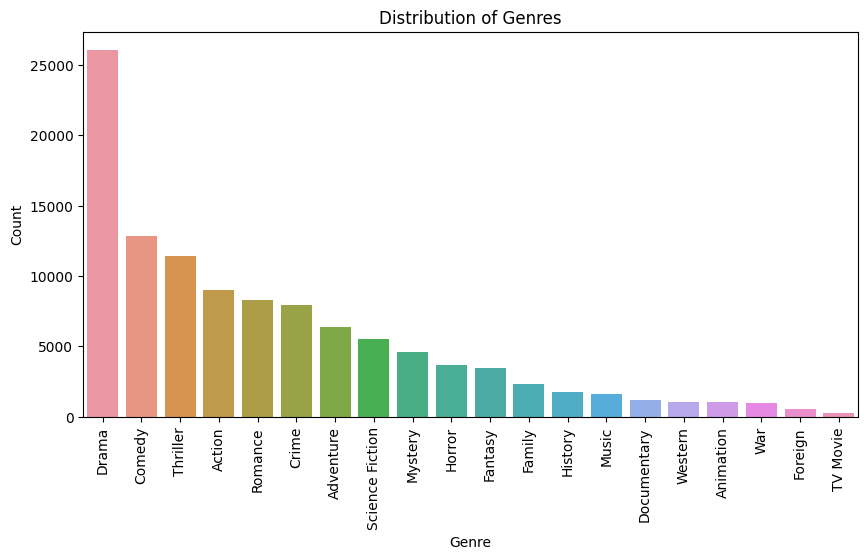

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x='genre', y='count', data=genre_counts)
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

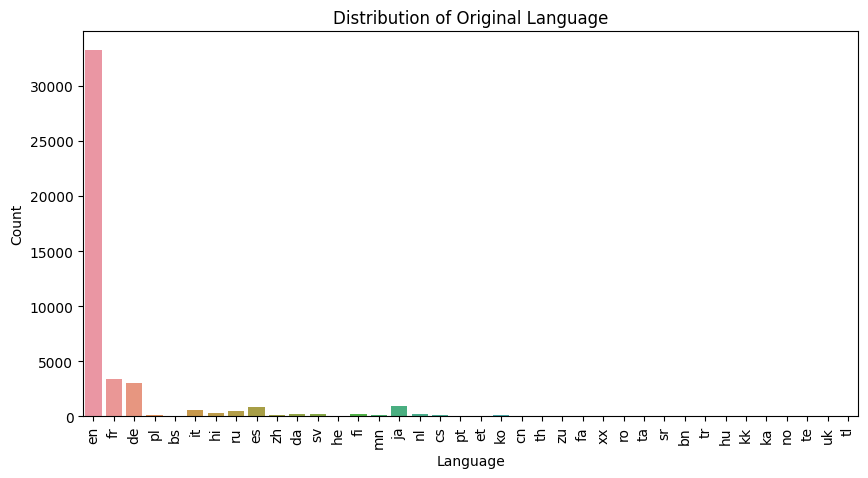

In [17]:
# Plot distribution of languages
plt.figure(figsize=(10, 5))
sns.countplot(data=combined_data, x='original_language')
plt.title('Distribution of Original Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [18]:
movies_df = movies_df.sort_index(axis=1)

In [19]:
movies_df.isnull().sum().sort_values(ascending=False)

belongs_to_collection    40972
homepage                 37684
tagline                  25054
overview                   954
poster_path                386
runtime                    263
status                      87
release_date                87
original_language           11
vote_count                   6
vote_average                 6
video                        6
title                        6
revenue                      6
spoken_languages             6
popularity                   5
production_countries         3
production_companies         3
original_title               0
genres                       0
budget                       0
adult                        0
dtype: int64

In [20]:
movies_df.shape

(45466, 22)

In [21]:
movies_df = movies_df.sort_values('popularity', ascending=False)
movies_df [['title', 'vote_count', 'vote_average', 'popularity']].head(15)

,title,vote_count,vote_average,popularity
id,,,,
0,NaN,NaN,NaN,Beware Of Frost Bites
85013,Hyper Sapien: People from Another Star,0.000,0.000,9e-06
96159,Chameli Ki Shaadi,0.000,0.000,9e-06
78,Blade Runner,"3,833.000",7.900,96.272374
10567,Dinosaur,563.000,6.200,9.998415
25,Jarhead,776.000,6.600,9.997032
7511,The Last Kiss,125.000,5.900,9.996541
69668,Dream House,401.000,5.800,9.995617
10549,Hamlet,118.000,7.300,9.994088


In [22]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.95)
print(f'C = {round(C,2)}, m = {round(m,2)}')

C = 5.62, m = 434.0


In [23]:
# Function that calculates imdb rating
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return ((R * v) + (C * m)) / (v + m)


movies_df['imdb_rating'] = movies_df.apply(weighted_rating, axis=1)
movies_df = movies_df.sort_index(axis=1)

In [24]:
movies_df = movies_df.sort_values('imdb_rating', ascending=False)
movies_df [['title', 'vote_count', 'vote_average', 'imdb_rating']].head(20)

,title,vote_count,vote_average,imdb_rating
id,,,,
278,The Shawshank Redemption,"8,358.000",8.500,8.358
238,The Godfather,"6,024.000",8.500,8.306
155,The Dark Knight,"12,269.000",8.300,8.208
550,Fight Club,"9,678.000",8.300,8.185
680,Pulp Fiction,"8,670.000",8.300,8.172
13,Forrest Gump,"8,147.000",8.200,8.069
424,Schindler's List,"4,436.000",8.300,8.061
244786,Whiplash,"4,376.000",8.300,8.058
129,Spirited Away,"3,968.000",8.300,8.036


In [25]:
movies_df['genres'] = movies_df['genres'] \
    .apply(lambda x: x[:3] if isinstance(x, list) else x)

In [26]:
top = gen_exp_df.sort_values('imdb_rating', ascending=False)


unique_values_list = list(top['genres'].unique())
values_to_exclude = ['TV Movie', 'Foreign', np.nan ]
filtered_list = list(filter(lambda x: x not in values_to_exclude, unique_values_list))

colors = sns.color_palette('colorblind', len(filtered_list))

plt.figure(figsize=(15,12))
for i in enumerate(filtered_list):
    plt.subplot(6,3, i[0]+1)
    top_movies_by_genre = top[top['genres'] == i[1]].head(5)
    plot = sns.barplot(x='imdb_rating', y='title', data=top_movies_by_genre, color=colors[i[0]])

    plt.title(i[1], fontsize=8) 
    plt.xlabel('imdb_rating', fontsize=6)
    plt.ylabel('')
plt.subplots_adjust(hspace=1.2, wspace=1)

NameError: name 'gen_exp_df' is not defined

In [ ]:
countries = movies_df.explode('production_countries')
q = countries['production_countries'].value_counts().head(30)


plt.figure(figsize= (20, 5))
plt.subplot(1,2,1)
plot = sns.barplot(x=q.index, y=q, data=countries)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8, rotation=90, horizontalalignment='right')
plt.ylabel('numbers of movies', fontsize=8)

plt.subplot(1,2,2)

countries = countries.query('production_countries != "United States of America"')
q = countries['production_countries'].value_counts().head(30)

plot = sns.barplot(x=q.index, y=q, data=countries)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8, rotation=90, horizontalalignment='right')
plt.ylabel('numbers of movies', fontsize=8)

plt.suptitle('Number of movies by production country', fontsize=16)

In [ ]:
# Which film genres are the most popular in Poland? 
poland_genre = countries.explode('genres')
poland_genre = poland_genre[poland_genre['production_countries'] == 'Poland']
poland_genre['genres'].value_counts().head(5)

In [ ]:
movies_df.columns

In [ ]:
cleaned_movies_df = movies_df.copy()
filt = (cleaned_movies_df['vote_average'] == 0) & (cleaned_movies_df['vote_count'] == 0)
cleaned_movies_df = cleaned_movies_df[~filt]

In [ ]:
filt = (cleaned_movies_df['release_date'].isna())
cleaned_movies_df = cleaned_movies_df[~filt]

In [ ]:
nan_variable = ['production_companies', 'production_countries', 'genres',  'original_language']
for i in nan_variable:
    cleaned_movies_df[i] = cleaned_movies_df[i].fillna('')

In [ ]:
# Runtime with outliars
q = cleaned_movies_df.dropna(subset=['runtime'])
plt.figure(figsize=(12, 4))
sns.histplot(data=q, x='runtime', color='#008080', alpha=0.6, label='runtime minutes', bins=30 )

median_runtime = cleaned_movies_df['runtime'].median()
cleaned_movies_df['runtime'] = cleaned_movies_df['runtime'].fillna(median_runtime)

In [ ]:
def remove_outliers_iqr(dataframe, column_name):
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]
    return filtered_data

In [ ]:
vote_cleaned = remove_outliers_iqr(cleaned_movies_df, 'vote_count')

plt.figure(figsize= (15, 3))
plt.subplot(1,2,1)
sns.histplot(data=vote_cleaned, x='vote_count', color="#4361EE", label='vote_count', bins=30)

plt.subplot(1,2,2)
sns.boxplot(data=vote_cleaned, x='vote_count',color="#4361EE")

plt.suptitle('vote_count hist and boxplot', fontsize=16)

In [ ]:
vote_avg_clean = remove_outliers_iqr(cleaned_movies_df, 'vote_average')

plt.figure(figsize= (15, 3))
plt.subplot(1,2,1)
sns.histplot(data=vote_avg_clean, x='vote_average', color="#4CC9F0", label='vote_average', bins=30)

plt.subplot(1,2,2)
vote_avg_clean = cleaned_movies_df.copy()
sns.boxplot(data=vote_avg_clean, x='vote_average',color="#4CC9F0")
plt.suptitle('vote_average hist and boxplot', fontsize=16)

In [ ]:
imdb_cleaned = remove_outliers_iqr(cleaned_movies_df, 'imdb_rating')

plt.figure(figsize= (15, 3))
plt.subplot(1,2,1)
sns.histplot(data=imdb_cleaned, x='imdb_rating', color="#CC99FF", label='vote_average', bins=10)

plt.subplot(1,2,2)
sns.boxplot(data=imdb_cleaned, x='imdb_rating',color="#CC99FF")
plt.suptitle('imdb_rating hist and boxplot', fontsize=16)